In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load datasets
train = pd.read_csv("train.csv", parse_dates=['date'])
val = pd.read_csv("val.csv", parse_dates=['date'])
test = pd.read_csv("test.csv", parse_dates=['date'])


In [4]:
# Ensure sorted
train = train.sort_values("date")
val = val.sort_values("date")
test = test.sort_values("date")

print("Regions:", train['Region'].unique())

Regions: ['East US' 'West US' 'North Europe' 'Southeast Asia']


In [5]:
# One-hot encode categorical features (like ResourceType)
cat_cols = ['ResourceType']
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
val = pd.get_dummies(val, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)

In [6]:
target = 'usage_cpu'

# Drop duplicates/unwanted columns
exclude_cols = [
    'date', 'region', 'Region', 'ResourceType', target,
    'ResourceType_Storage', 'ResourceType_VM'  # duplicate dummies
]

features = [col for col in train.columns if col not in exclude_cols]
print("✅ Final features used:", features)

results = []

✅ Final features used: ['usage_storage', 'users_active', 'economic_index', 'cloud_market_demand', 'holiday', 'Day_of_Week', 'Month', 'month', 'day_of_week', 'is_weekend', 'quarter', 'usage_cpu_lag1', 'usage_cpu_lag3', 'usage_cpu_lag7', 'cpu_roll_mean_7', 'cpu_roll_max_7', 'cpu_roll_min_7', 'cpu_roll_mean_30', 'cpu_roll_max_30', 'cpu_roll_min_30', 'cpu_total', 'cpu_utilization', 'storage_allocated', 'storage_efficiency', 'weather_index', 'power_outage_flag', 'price_change', 'region_EAST US', 'region_NORTH EUROPE', 'region_SOUTHEAST ASIA', 'region_WEST US', 'resource_type_Container', 'resource_type_Storage', 'resource_type_VM']



🔹 Training XGBoost for region: East US


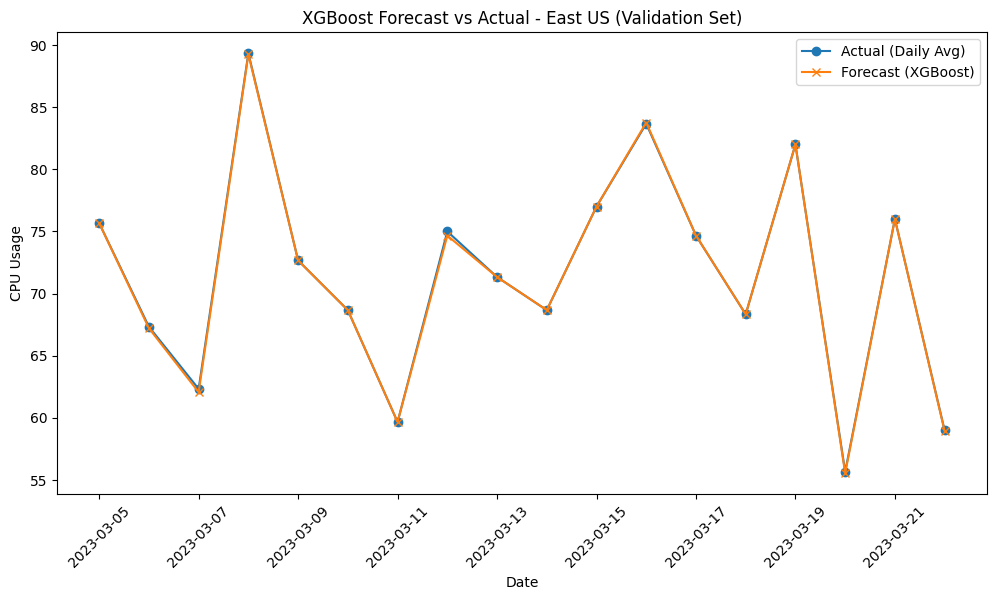


🔹 Training XGBoost for region: West US


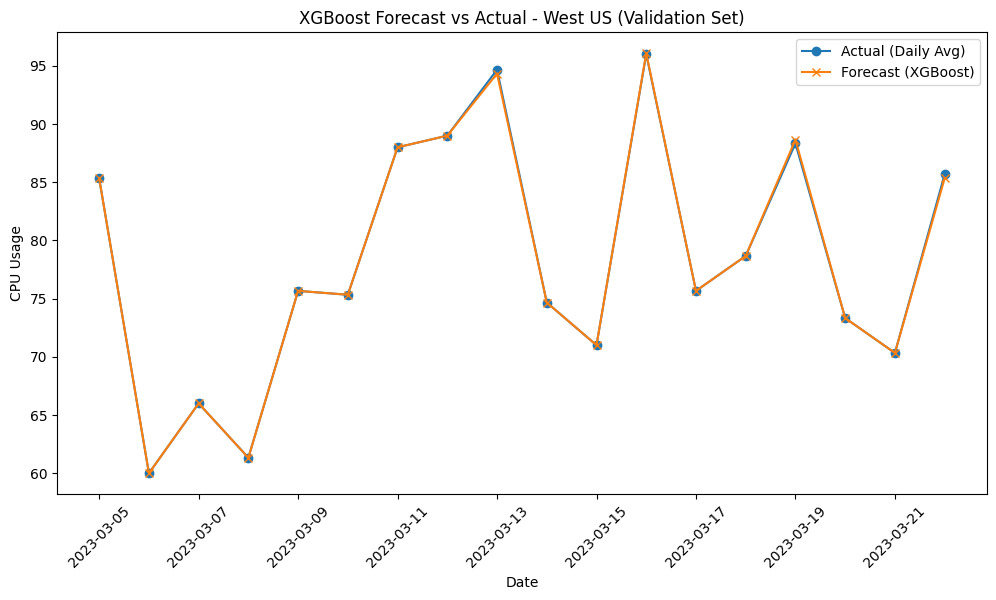


🔹 Training XGBoost for region: North Europe


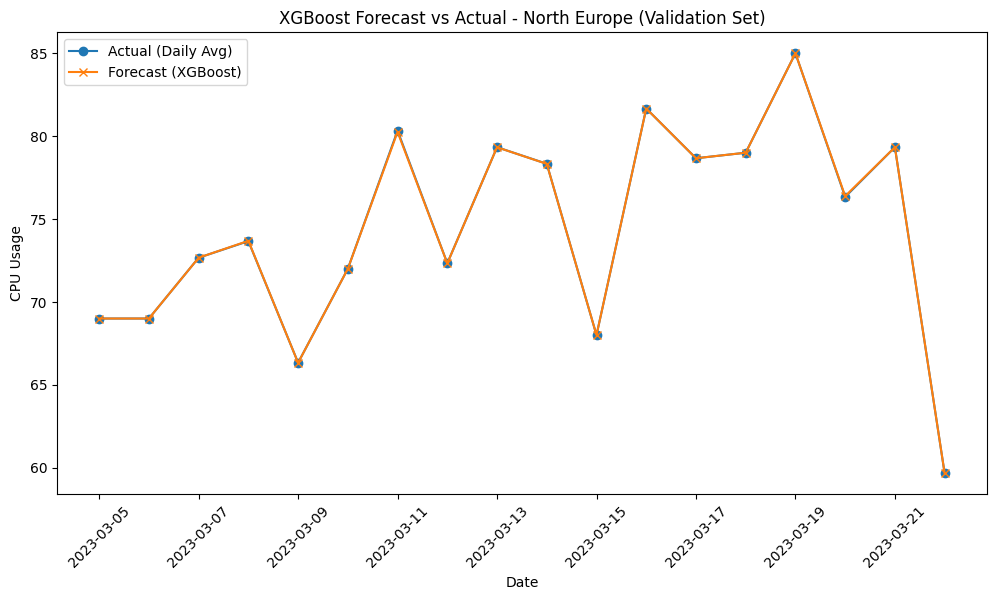


🔹 Training XGBoost for region: Southeast Asia


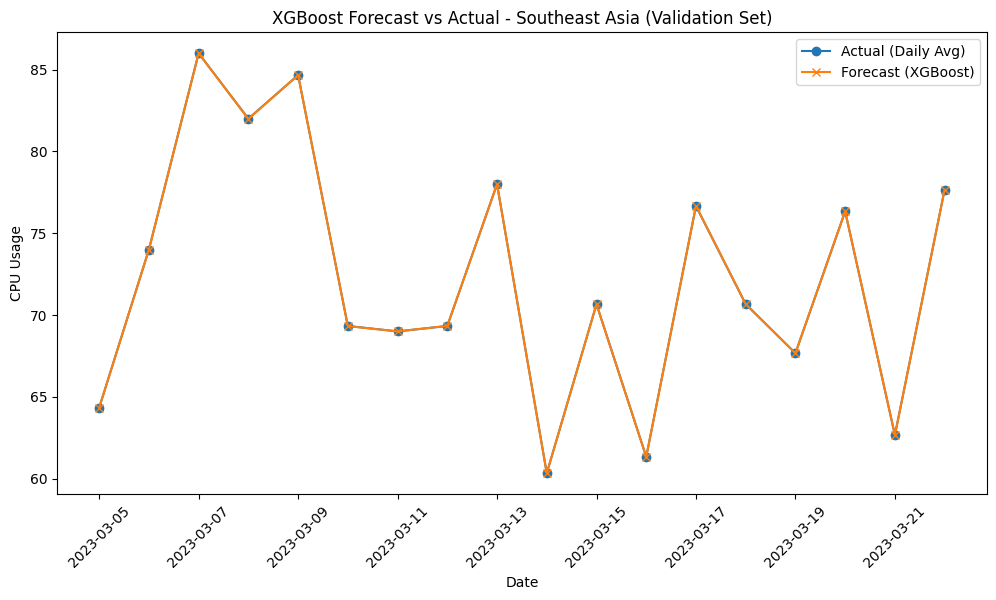


✅ XGBoost Validation Completed!
     Model          Region   MAE  RMSE   MAPE
0  XGBoost         East US  0.07  0.20  0.12%
1  XGBoost         West US  0.06  0.24  0.07%
2  XGBoost    North Europe  0.01  0.04  0.01%
3  XGBoost  Southeast Asia  0.00  0.01  0.00%


In [7]:
# Validation per region
# -------------------------------
for Region in train['Region'].unique():
    print(f"\n🔹 Training XGBoost for region: {Region}")

    X_train = train[train['Region']==Region][features]
    y_train = train[train['Region']==Region][target]

    X_val = val[val['Region']==Region][features]
    y_val = val[val['Region']==Region][target]

    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_pred = model.predict(X_val)

    # Metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

    results.append({
        "Model": "XGBoost",
        "Region": Region,
        "MAE": round(mae,2),
        "RMSE": round(rmse,2),
        "MAPE": f"{mape:.2f}%"
    })

    # Aggregate by date for clean plotting
    val_region = val[val['Region']==Region].groupby('date')['usage_cpu'].mean()
    pred_region = pd.Series(y_pred, index=val[val['Region']==Region]['date'])

    # Align indexes
    pred_region = pred_region.groupby(pred_region.index).mean()

    plt.figure(figsize=(12,6))
    plt.plot(val_region.index, val_region.values, label="Actual (Daily Avg)", marker='o')
    plt.plot(pred_region.index, pred_region.values, label="Forecast (XGBoost)", marker='x')
    plt.xlabel("Date")
    plt.ylabel("CPU Usage")
    plt.title(f"XGBoost Forecast vs Actual - {Region} (Validation Set)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()


# Save validation metrics
df_results = pd.DataFrame(results)
df_results.to_csv("metrics_xgb.csv", index=False)

print("\n✅ XGBoost Validation Completed!")
print(df_results)


🔮 Final Test Forecast for region: East US


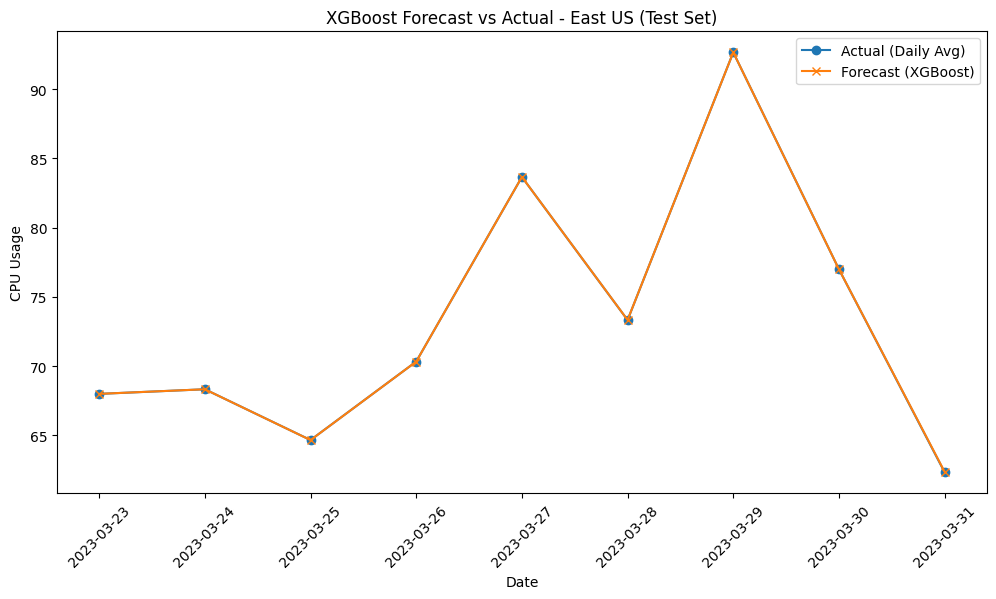


🔮 Final Test Forecast for region: West US


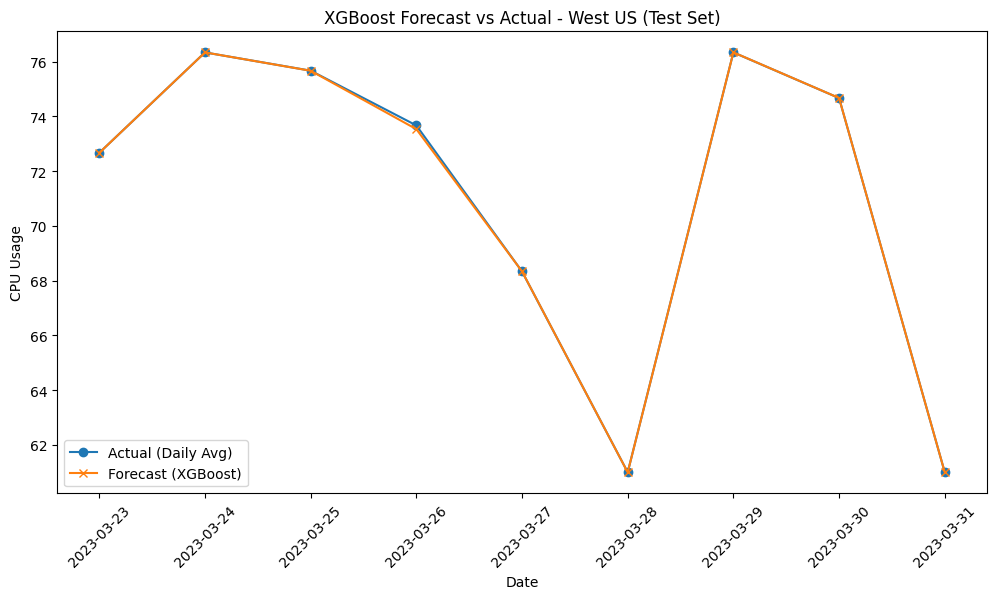


🔮 Final Test Forecast for region: North Europe


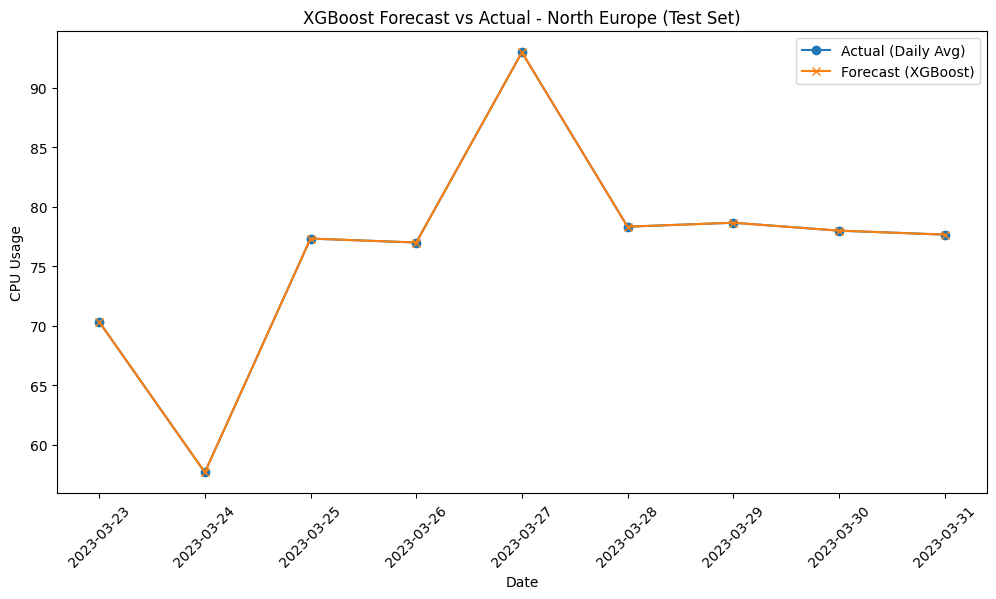


🔮 Final Test Forecast for region: Southeast Asia


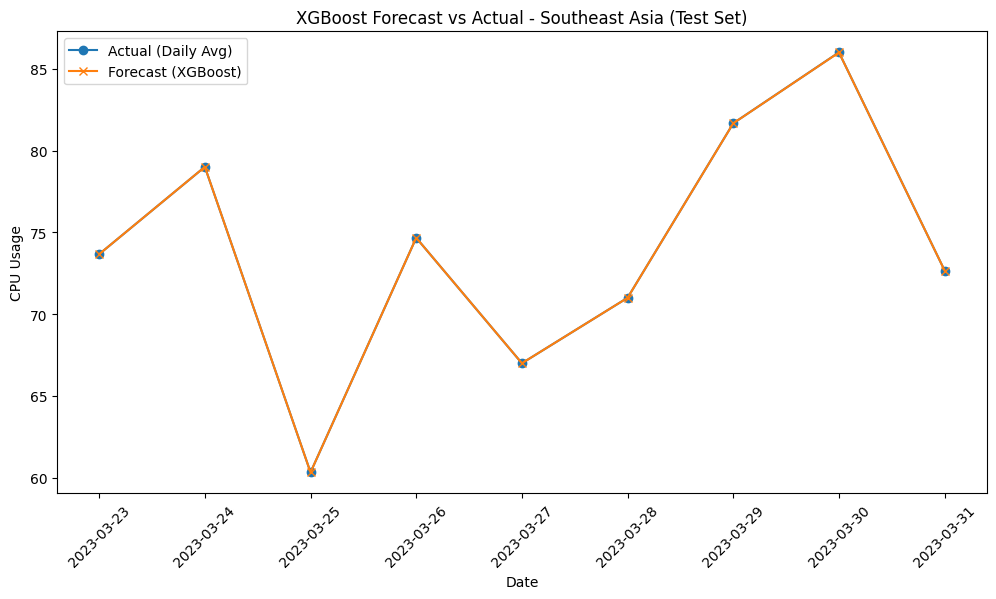


✅ Final Test Forecast Completed!
     Model          Region   MAE  RMSE   MAPE
0  XGBoost         East US  0.01  0.02  0.01%
1  XGBoost         West US  0.02  0.08  0.02%
2  XGBoost    North Europe  0.00  0.00  0.00%
3  XGBoost  Southeast Asia  0.00  0.00  0.00%


In [8]:
# Final Test Forecast per Region
# -------------------------------
test_results = []
all_forecasts = []

for Region in train['Region'].unique():
    print(f"\n🔮 Final Test Forecast for region: {Region}")

    X_train_val = pd.concat([
        train[train['Region']==Region],
        val[val['Region']==Region]
    ])
    y_train_val = X_train_val[target]
    X_train_val = X_train_val[features]

    X_test = test[test['Region']==Region][features]
    y_test = test[test['Region']==Region][target]

    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_val, y_train_val, verbose=False)

    y_pred = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    test_results.append({
        "Model": "XGBoost",
        "Region": Region,
        "MAE": round(mae,2),
        "RMSE": round(rmse,2),
        "MAPE": f"{mape:.2f}%"
    })

    # Store forecast for CSV
    forecast_dates = test[test['Region']==Region]['date'].values
    all_forecasts.extend(zip([Region]*len(forecast_dates), forecast_dates, y_pred.flatten()))

    # Aggregate by date for clean plotting
    test_region = test[test['Region']==Region].groupby('date')['usage_cpu'].mean()
    pred_region = pd.Series(y_pred, index=test[test['Region']==Region]['date'])
    pred_region = pred_region.groupby(pred_region.index).mean()

    plt.figure(figsize=(12,6))
    plt.plot(test_region.index, test_region.values, label="Actual (Daily Avg)", marker='o')
    plt.plot(pred_region.index, pred_region.values, label="Forecast (XGBoost)", marker='x')
    plt.xlabel("Date")
    plt.ylabel("CPU Usage")
    plt.title(f"XGBoost Forecast vs Actual - {Region} (Test Set)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()


# Save test metrics
df_test_results = pd.DataFrame(test_results)
df_test_results.to_csv("metrics_xgb_test.csv", index=False)

# Save forecasts
forecast_df = pd.DataFrame(all_forecasts, columns=["Region","Date","Forecasted_CPU_Usage"])
forecast_df.to_csv("xgb_test_forecast.csv", index=False)

print("\n✅ Final Test Forecast Completed!")
print(df_test_results)


In [9]:
import joblib

# Suppose 'model' is your trained XGBoost model
joblib.dump(model, "xgb_model.pkl")
print("✅ Model saved as xgb_model.pkl")


✅ Model saved as xgb_model.pkl


In [10]:
import joblib

joblib.dump(model, "final_model.pkl")


['final_model.pkl']

In [1]:
import joblib

model = joblib.load("final_model.pkl")
print(model.feature_names_in_)  # prints columns expected by the model


['usage_storage' 'users_active' 'economic_index' 'cloud_market_demand'
 'holiday' 'Day_of_Week' 'Month' 'month' 'day_of_week' 'is_weekend'
 'quarter' 'usage_cpu_lag1' 'usage_cpu_lag3' 'usage_cpu_lag7'
 'cpu_roll_mean_7' 'cpu_roll_max_7' 'cpu_roll_min_7' 'cpu_roll_mean_30'
 'cpu_roll_max_30' 'cpu_roll_min_30' 'cpu_total' 'cpu_utilization'
 'storage_allocated' 'storage_efficiency' 'weather_index'
 'power_outage_flag' 'price_change' 'region_EAST US' 'region_NORTH EUROPE'
 'region_SOUTHEAST ASIA' 'region_WEST US' 'resource_type_Container'
 'resource_type_Storage' 'resource_type_VM']
